In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Required Packages:

In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Drone_Delivery/')

from Coordinates import Polygon_points, IDs, Pr_sub, Pr_region, IDs_dict


import numpy as np
import matplotlib.pyplot as plt 
import math
import random
from tqdm import tqdm
import gym
from gym import spaces
import copy
from shapely.geometry import Polygon, Point

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple

import warnings
#warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)




### Parameters of the system:

In [ ]:
Total_area = 36.3

Initial_Energy = 100
v = 5

arriv_rate_avg = np.zeros(4)
for d in range(4):
  arriv_rate_avg[d] = (Pr_region[d]*55)/Pr_region[0]

Central_scheduler_Loc = [6678.899082568796, -4568.807339449534]
delta_t = 60
depots_Loc = [[3669.724770642196, -3633.027522935774],
              [7229.357798165125, -2311.926605504583],
              [5834.862385321091, -6788.990825688062],
              [9100.917431192645, -5834.862385321091], 
              [6678.899082568796, -4568.807339449534]]







def Dec2Bin(x, L):
  x = min(x, 2**L - 1)
  out = []
  while x > 0:
    r = x % 2
    out.append(r)
    x = x // 2
  if len(out) < L:
    delta_l = L - len(out)
    for _ in range(delta_l):
      out.append(0)
  out.reverse()
  return out 



def Dec2Onehot(x, L, max_):
  out = np.zeros(L)
  m = max_ // L
  divisor = x // m
  if int(divisor) < L:
    out[int(divisor)] = 1
  else:
    out[L-1] = 1
  
  return list(out) 





def Points_division(L, Pr):
  out = []
  for i in range(len(Pr)):
    out.append(int(L * Pr[i]))
  #print(out)
  return out
    

def get_random_point_in_polygon(poly):
     minx, miny, maxx, maxy = poly.bounds
     while True:
         p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
         if poly.contains(p):
             return p


In [ ]:
arriv_rate_avg

array([55.   , 51.15 , 76.725, 92.125])

### Environment:

In [ ]:
class Drone_Delivery(gym.Env):
  def __init__(self,n_depots, n_UAVs, m_0):
    self.epsilon = 0.1
    self.dual_multiplier = 4
    self.n_depots = n_depots
    self.time = 0 
    self.n_UAVs = n_UAVs
    self.UAVs = [UAV(i) for i in range(self.n_UAVs)]
    self.depots = [depot(id) for id in range(self.n_depots)]
    self.depots.append(depot(-1))
    self.T_action = 120
    self.n_Q_bits = 20
    self.n_UAV_bits = 10
    self.state = np.zeros((self.n_depots, self.n_Q_bits + self.n_UAV_bits ))
    self.q_thr = [80, 80, 120, 150]
    # [80, 80, 120, 150]
    #[120, 110, 165, 200]
    self.p_arrival = [0.65, 0.65, 0.65, 0.65]
    self.actionspace = {0: -5, 1: 0, 2: 5}
    self.m_0 = m_0 

    #self.action_space = spaces.Discrete(3)
    # The observation will be the coordinate of the agent
    # this can be described both by Discrete and Box space
    #self.observation_space = spaces.Box(low=0, high=1,
    #                                    shape=(1,self.n_Q_bits + self.n_UAV_bits), dtype=np.float32)





    #Initialize UAVs (equally) to the depots:
    for d in range(self.n_depots):
      if d == 0: 
        l_b = 0
      else:
        l_b = np.sum(self.m_0[0: d])
      for i in range(l_b, np.sum(self.m_0[0:d+1])):
        self.UAVs[i].depot = d 
        self.UAVs[i].status = 0
        self.UAVs[i].Loc = self.depots[d].Loc
        self.depots[d].UAV_ids.append(self.UAVs[i].id)
        self.depots[d].empty_UAVs.append(self.UAVs[i].id)


    for i in range(np.sum(self.m_0), self.n_UAVs):
      self.UAVs[i].depot = -1
      self.UAVs[i].status = 0
      self.UAVs[i].Loc = self.depots[-1].Loc
      self.depots[-1].UAV_ids.append(self.UAVs[i].id)
      self.depots[-1].empty_UAVs.append(self.UAVs[i].id)



    for d in range(self.n_depots):
      q_len = len(self.depots[d].Q)
      uav_len = len(self.depots[d].UAV_ids)
      #print(q_len)
      #self.state[d] = [q_len, uav_len]
      self.state[d] = Dec2Bin(q_len, self.n_Q_bits) + Dec2Bin(uav_len, self.n_UAV_bits)
      #self.state[d] = Dec2Onehot(q_len, self.n_Q_bits, 1000) + Dec2Onehot(uav_len, self.n_UAV_bits, 500)
      



  def reset(self):
    self.time = 0
    self.p_arrival = [0.65, 0.65, 0.65, 0.65]

    for d in range(self.n_depots):
      self.depots[d].delivered = 0
      self.depots[d].Q = []
      self.depots[d].UAV_ids = []
      self.depots[d].returning_UAVs = []
      self.depots[d].delivering_UAVs = []
      self.depots[d].empty_UAVs = []
      self.depots[d].status = 1

      
      
      if d ==0:
        l_b = 0
      else:
        l_b = np.sum(self.m_0[0: d])

      for i in range(l_b, np.sum(self.m_0[0:d+1])):
        self.UAVs[i].depot = d 
        self.UAVs[i].status = 0
        self.UAVs[i].transit_flag = False
        self.UAVs[i].Loc = self.depots[d].Loc
        self.depots[d].UAV_ids.append(self.UAVs[i].id)
        self.depots[d].empty_UAVs.append(self.UAVs[i].id)




    
    self.depots[-1].returning_UAVs = []
    self.depots[-1].delivering_UAVs = []
    self.depots[-1].empty_UAVs = []
    self.depots[-1].UAV_ids = []
    for i in range(np.sum(self.m_0), self.n_UAVs):
      
      self.UAVs[i].depot = -1
      self.UAVs[i].status = 0
      self.UAVs[i].transit_flag = False
      self.UAVs[i].Loc = self.depots[-1].Loc
      self.depots[-1].UAV_ids.append(self.UAVs[i].id)
      self.depots[-1].empty_UAVs.append(self.UAVs[i].id)


    
    for d in range(self.n_depots):
      q_len = len(self.depots[d].Q)
      uav_len = len(self.depots[d].UAV_ids)
      #self.state[d] = [q_len, uav_len]
      self.state[d] = Dec2Bin(q_len, self.n_Q_bits) + Dec2Bin(uav_len, self.n_UAV_bits)
      #self.state[d] = Dec2Onehot(q_len, self.n_Q_bits, 1000) + Dec2Onehot(uav_len, self.n_UAV_bits, 500)
    
    s = copy.deepcopy(self.state)
    return s

##############################################################


  def step(self, action):
    N_Q_violate = np.zeros(self.n_depots)
    act = []
    for dd in range(self.n_depots):
      act.append(self.actionspace[action[dd]])
      #act.append(action[dd])
    
    
    #act_0 = self.actionspace[action]
    #act = [act_0]
    #act = [0]
    #for _ in range(1, self.n_depots):
    #  act.append(np.random.randint(-5,6))
      #act.append(0)

    #act = np.random.randint(-5,6, size= self.n_depots)
    self.central_scheduller_2(act)
    #print(act)
    reward = np.zeros(self.n_depots)
    reward_sub = np.zeros(self.n_depots) 
    q_len = np.zeros(self.n_depots)
    uav_len = np.zeros(self.n_depots)

    #if self.time % 300 ==0:
    #  self.p_arrival[0] = 0.1
    #  self.p_arrival[2] = 0.1
    #  self.p_arrival[1] = 0.9
    #  self.p_arrival[3] = 0.9
    #if self.time % 600 ==0:
    #  self.p_arrival[0] = 0.9
    #  self.p_arrival[2] = 0.9
    #  self.p_arrival[1] = 0.1
    #  self.p_arrival[3] = 0.1


    for tt in range(self.T_action):
      self.time += 1
      for d in range(self.n_depots):
        arr = np.random.uniform() > self.p_arrival[d]
        if arr and tt % 45 == 0:

          ar_rate = int(1.2*arriv_rate_avg[d])
          self.customer_generation(d, self.time, ar_rate)
        
        delivered_old = self.depots[d].delivered
        self.depots[d].UAV_customer_assignment(self.UAVs, self.time)
      


        


      # for depot 0:
      delivered_new = self.depots[0].delivered



      self.UAVs_move()

      delta_delivery = delivered_new - delivered_old 

      for d in range(self.n_depots):
        q_len[d] = len(self.depots[d].Q)
        uav_len[d] = len(self.depots[d].UAV_ids)
        #self.state[d] = [q_len[d], uav_len[d]]
        self.state[d] = Dec2Bin(q_len[d], self.n_Q_bits) + Dec2Bin(uav_len[d], self.n_UAV_bits)
        #self.state[d] = Dec2Onehot(q_len, self.n_Q_bits, 1000) + Dec2Onehot(uav_len, self.n_UAV_bits, 500)
        #Q[d].append(q_len[d])

        #reward_sub[d] += max(delta_delivery, 0)


        if q_len[d] > self.q_thr[d]:
          N_Q_violate[d] += 1
          reward_sub[d] += self.epsilon * self.dual_multiplier - self.dual_multiplier
        elif q_len[d] <= self.q_thr[d]:
          reward_sub[d] += self.epsilon * self.dual_multiplier
        #else: 
          #reward_sub[d] += -200000


      

    for d in range(self.n_depots):
      reward[d] = reward_sub[d]  - 1*len(self.depots[d].UAV_ids)
      #reward[d] = - len(self.depots[d].UAV_ids)

    #reward = reward/100
    s = copy.deepcopy(self.state)

    
    return s, reward, False, N_Q_violate






  def central_scheduller_2(self, delta_n):
    """
    delta_n is the incremental action
    """
    N = np.zeros((self.n_depots,), dtype=int)
    delta = np.zeros((self.n_depots,), dtype=int)
    UnAssigned_UAVs = []
    Awaiting_depots = []
    for d in range(self.n_depots):
      N[d] = len(self.depots[d].UAV_ids) + delta_n[d]
      if N[d] < 0:
        delta_n[d] = 0
    if sum(delta_n) > 0:
      if sum(delta_n) <= len(self.depots[-1].UAV_ids):
        for _ in range( min(sum(delta_n),len(self.depots[-1].UAV_ids)) ):
          u = self.depots[-1].UAV_ids.pop(0)
          self.UAVs[u].transit_flag = True
          #self.UAVs[u].Loc = [np.random.uniform(1,8000), np.random.uniform(4000,8000)]
          self.UAVs[u].Loc = [6678.899082568796, -4568.807339449534]
          self.depots[-1].empty_UAVs.remove(u)
          UnAssigned_UAVs.append(u)
      #else:
      #  for d in range(self.n_depots):
      #    N[d] = max(len(self.depots[d].UAV_ids) + delta_n[d], 0)
      #    N[d] = min(len(self.depots[d].UAV_ids) + delta_n[d],self.n_UAVs)
      #  N_tilde = (N*self.n_UAVs)/np.sum(N)
        
      #  for d in range(self.n_depots):
      #    N_tilde[d] = int(N_tilde[d] + 1) if (N_tilde[d] % 1 >=0.5) else int(N_tilde[d])
      #    delta[d] = N_tilde[d] - len(self.depots[d].UAV_ids)
      #  print(N_tilde)
    delta = delta_n
    
    for d in range(self.n_depots):
      #delta[d] = N[d] - len(self.depots[d].UAV_ids)
      if delta[d] > 0:
        Awaiting_depots.append([d,delta[d]])
      elif delta[d] < 0:
        l_1 = len(self.depots[d].empty_UAVs)
        if l_1 >= abs(delta[d]):
          for _ in range(abs(delta[d])):
            u = self.depots[d].empty_UAVs.pop(0)
            self.UAVs[u].transit_flag = True
            self.depots[d].UAV_ids.remove(u)
            UnAssigned_UAVs.append(u)
            self.UAVs[u].depot = -1
        elif l_1 < abs(delta[d]):
          for _ in range(max(l_1,0)):
            u = self.depots[d].empty_UAVs.pop(0)
            self.UAVs[u].transit_flag = True
            self.depots[d].UAV_ids.remove(u)
            UnAssigned_UAVs.append(u)
            self.UAVs[u].depot = -1
          l_2 = abs(delta[d]) - l_1
          l_r = len(self.depots[d].returning_UAVs)
          if l_r >= l_2: 
            for _ in range(l_2):
              u = self.depots[d].returning_UAVs.pop()
              self.UAVs[u].transit_flag = True
              #print('returning')
              #print(u)
              #print(self.depots[d].returning_UAVs)
              #print(self.depots[d].UAV_ids)
              self.depots[d].UAV_ids.remove(u)
              UnAssigned_UAVs.append(u)
              self.UAVs[u].depot = -1
          elif l_r < l_2:
            for _ in range(max(l_r,0)):
              #print(d)
              u = self.depots[d].returning_UAVs.pop()
              self.UAVs[u].transit_flag = True
              self.depots[d].UAV_ids.remove(u)
              UnAssigned_UAVs.append(u)
              self.UAVs[u].depot = -1
            l_3 = l_2 - l_r
            #l_d = len(self.depots[d].delivering_UAVs)
            for _ in range(l_3):
              #List_d = self.depots[d].delivering_UAVs.copy()
              #List_d.reverse() 
              #u = List_d.pop()
              u = self.depots[d].delivering_UAVs.pop(0)
              self.UAVs[u].transit_flag = True
              #self.depots[d].delivering_UAVs.remove(u)
              self.depots[d].UAV_ids.remove(u)
              UnAssigned_UAVs.append(u)
              self.UAVs[u].depot = -1
    #print("Originally unassigned {}".format(len(UnAssigned_UAVs)))
    if len(Awaiting_depots) != 0:
      for d_ in Awaiting_depots:
        depot_id = d_[0]
        if len(UnAssigned_UAVs) != 0:
          distances_ = [ np.linalg.norm( np.subtract(self.UAVs[u].Loc, self.depots[depot_id].Loc) ) for u in UnAssigned_UAVs]

          sorted_UAVs = [x for _,x in sorted(zip(distances_, UnAssigned_UAVs))]
          selected_UAVs = sorted_UAVs[0:min(d_[1],len(sorted_UAVs)) ]
          for u in selected_UAVs:
            self.UAVs[u].depot = depot_id
            self.UAVs[u].transit_flag = True
            self.depots[depot_id].UAV_ids.append(u)
            UnAssigned_UAVs.remove(u)
        #self.depots[depot_id].UAV_ids.extend(selected_UAVs)
      #UnAssigned_UAVs = []
      #Awaiting_depots = []

    if len(UnAssigned_UAVs) != 0:
      #print(len(UnAssigned_UAVs))
      for u in UnAssigned_UAVs:
        self.UAVs[u].depot = -1 
        self.UAVs[u].transit_flag = True
        self.depots[-1].UAV_ids.append(u)


    #return Awaiting_depots, UnAssigned_UAVs







    


  

  def customer_generation(self, depot_id, arrival_time, n_customers):
    
    N_customer_each_subzone = Points_division(n_customers, Pr_sub[depot_id])
    for i in range(5):
      id = IDs_dict[depot_id][i]
      poly = Polygon(Polygon_points[id])
      L = N_customer_each_subzone[i]
      if L > 0:
        LL = np.copy(L)
        while LL > 0 :
          destination = get_random_point_in_polygon(poly)
          self.depots[depot_id].Q.append(Customer(depot_id, arrival_time, destination))
          LL -= 1
      






  def UAVs_move(self):

    #for d in self.depots:
    #  d.UAV_customer_assignment(self.UAVs)

    for u in self.UAVs:

      if u.status == 2 and u.transit_flag == False:
        u.movement()

        if np.linalg.norm(np.subtract(u.Loc,u.destination)) ==0: 
          u.status =0
          self.depots[u.depot].empty_UAVs.append(u.id)
          self.depots[u.depot].returning_UAVs.remove(u.id)
          


      elif u.status == 2 and u.transit_flag == True:
        u.transit_flag = False
        u.destination = self.depots[u.depot].Loc
        self.depots[u.depot].returning_UAVs.append(u.id)
        u.movement()

        if np.linalg.norm(np.subtract(u.Loc,u.destination)) ==0: 
          u.status =0
          self.depots[u.depot].empty_UAVs.append(u.id)
          self.depots[u.depot].returning_UAVs.remove(u.id)

      elif u.status == 1:
        u.movement()
        if np.linalg.norm(np.subtract(u.Loc,u.destination)) ==0:
          u.status =2
          u.destination = self.depots[u.depot].Loc
          if u.transit_flag == False:
            self.depots[u.depot].delivering_UAVs.remove(u.id)
            self.depots[u.depot].returning_UAVs.append(u.id)

          #elif u.transit_flag == True:
          #  self.depots[u.depot].returning_UAVs.append(u.id)
          #  u.transit_flag = False
          #if u.transit_flag == False:
          #  self.depots[u.depot].returning_UAVs.append(u.id)

          
      
      elif u.status == 0 and u.transit_flag == True:
        u.status = 2
        self.depots[u.depot].returning_UAVs.append(u.id)
        u.transit_flag = False
        u.destination = self.depots[u.depot].Loc
        u.movement()
        if np.linalg.norm(np.subtract(u.Loc,u.destination)) ==0: 
          u.status =0
          self.depots[u.depot].returning_UAVs.remove(u.id)
          self.depots[u.depot].empty_UAVs.append(u.id)



        


########################
class UAV(object):
  def __init__(self, id):
    self.id = id
    
    self.depot = -1
    self.status = 0 # 0: idle, 1: towards delivery, 2: back from delivery
    self.energy = Initial_Energy
    self.Loc = Central_scheduler_Loc
    self.destination = []
    self.transit_flag = False


  def movement(self):
    normal_direction = np.subtract(self.destination, self.Loc)/np.linalg.norm(np.subtract(self.destination, self.Loc))
    V = v*normal_direction
    if np.linalg.norm(np.subtract(self.destination, self.Loc)) <= v*delta_t:
      self.Loc = self.destination
    else: 
      self.Loc += V * delta_t 
    
    self.energy -= 1





##########################
class depot(object):
  def __init__(self, depot_id):
    self.depot_id = depot_id
    self.Loc = depots_Loc[self.depot_id]
    self.UAV_ids = [] #Total UAVs of the depot. UAV_ids 
    self.Q = []
    self.empty_UAVs = []
    self.returning_UAVs = []
    self.delivering_UAVs = []
    self.delivered = 0
    self.served_customers = []
    self.status = 1


  def UAV_customer_assignment(self, UAVs, current_time):
    l_e = len(self.empty_UAVs)
    l_q = len(self.Q)
    self.delivered += min(l_e,l_q)
    for _ in range(min(l_e,l_q)):
      c = self.Q.pop(0)
      c.departure_time = current_time
      self.served_customers.append(c)
      uav_id = self.empty_UAVs.pop(0)
      self.delivering_UAVs.append(uav_id)
      UAVs[uav_id].destination = c.address
      UAVs[uav_id].status = 1



class Customer(object):
  def __init__(self, depot_id, arrival_time, destination):
    self.depot = depot_id
    self.address = destination
    self.delivered = False
    self.arrival_time = arrival_time
    self.departure_time = arrival_time
    self.deliver_time = 0
    self.customer_id = []

# Parameters of the Neural Network:

### We use DDQN for our learning

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

TARGET_UPDATE = 5
num_episodes = 120
hidden = 256
gamma = 0.99
replay_buffer_size = 1000000
batch_size = 25
eps_stop = 0.05
epsilon = 0.5
eps = 0.5
Start_epsilon_decaying=0
End_epsilon_decaying=num_episodes//2
epsilon_decaying= epsilon/(End_epsilon_decaying-Start_epsilon_decaying)


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DDQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim, hidden):
        super(DDQN, self).__init__()
        #self.hidden = hidden
        self.fc1 = nn.Linear(state_space_dim, 32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32, action_space_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.3)
        #x = F.relu(x)
        x = F.relu(self.fc2(x))
        #x = self.fc2(x)
        #x = F.relu(x)
        x = self.fc3(x)
        return x


class DDQNAgent(object):
    def __init__(self, state_space, n_actions, replay_buffer_size,
                 batch_size, hidden_size, gamma):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_actions = n_actions
        self.state_space_dim = state_space
        self.policy_net = DDQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net = DDQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.memory = ReplayMemory(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

    def update_network(self, updates=1):
        for _ in range(updates):
            self._do_network_update()

    def _do_network_update(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal, s in zip(non_final_mask,
                                                          batch.next_state) if nonfinal > 0]
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon):
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
            return random.randrange(self.n_actions)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        next_state = torch.from_numpy(next_state).float()
        state = torch.from_numpy(state).float()
        self.memory.push(state, action, next_state, reward, done)

In [ ]:
n_actions = 3
state_space_dim = 30
agent = DDQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                  hidden, gamma)

In [ ]:
env = Drone_Delivery(1,4000)
env.reset()
random.seed(8)
np.random.seed(8)
n_actions = 3
state_space_dim = 30
agent = DDQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                  hidden, gamma)




average_rewards = []
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = []
n_UAVs = []
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    eps -= epsilon_decaying
    epsilon = max(0.05 , eps)
    cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots) #Number of queue length violation per episode (1000 hours)


    test_n_UAVs = []
    test_Q_len = []

    while step_counter > 0 and len(env.depots[0].Q) < 2000:
      count +=1
      step_counter -= 1
      action = agent.get_action(state, epsilon)
      #print("state_be=", state, "action=", action)
      next_state, reward, done, NN = env.step(action) #NN: number of Q length violation per step (60 min)
      cum_reward += reward
      #print("state_af=",next_state)
      #print("------------------------") 
      agent.store_transition(state, action, next_state, reward, done)
      
      agent.update_network()


      Q_end_episode.append(len(env.depots[0].Q))
      for d in range(env.n_depots):
        NN_p[d] = NN_p[d] + NN[d]
        #N_violation_per_episode[d].append(NN[d])

      state = next_state
      n_UAVs.append(len(env.depots[0].UAV_ids))
      test_n_UAVs.append(len(env.depots[0].UAV_ids))
      test_Q_len.append(len(env.depots[0].Q))





    if ep % TARGET_UPDATE == 0:
      agent.update_target_network()
    
    
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p/(count*env.T_action))

    
    print("reward: {}, prob: {}".format(cum_reward/count, NN_p/(count*env.T_action)))

    average_rewards.append(cum_reward/count)

    plt.subplot(1,2,1)
    plt.plot(range(len(test_n_UAVs)), test_n_UAVs, label ='number of UAVs', color = 'b')
    plt.subplot(1,2,2)
    plt.plot(range(len(test_Q_len)), test_Q_len, label ='length of Queue', color = 'r')
    plt.legend()
    plt.show()
    
#env.close()
plt.plot(range(num_episodes),average_rewards,label='cumulative rewards', color = 'b')

plt.show()

plt.plot(range(num_episodes),Violation_prob[0],label='violation prob', color = 'r')

plt.show()

#plt.plot(range(len(Q_len)), Q_len, color = 'b')
#plt.show()
#print('Complete')

Save the results

In [ ]:
np.save('Reward_d0_Feb12_seed_08', average_rewards)
np.save('Pr_d0_Feb12_seed_08',Violation_prob[0])

In [ ]:
plt.plot(range(len(average_rewards)),average_rewards,label='average rewards', color = 'b')

plt.show()
W = 10
windowed_reward = np.zeros(len(average_rewards) - W)
for j in range(len(windowed_reward)):
  windowed_reward[j] = np.mean(average_rewards[j:j+W]) 

plt.plot(range(len(windowed_reward)),windowed_reward,label='windowed cumulative rewards', color = 'b')

plt.show()




plt.plot(range(len(Violation_prob[0])), Violation_prob[0], color = 'b')
plt.plot(range(len(Violation_prob[0])), 0.1*np.ones(len(Violation_prob[0])), color ='r')

# Test the code:

### DDQN based


  0%|          | 0/1 [00:00<?, ?it/s]

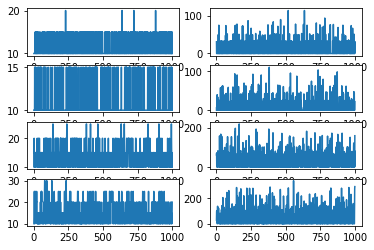


100%|██████████| 1/1 [03:36<00:00, 216.07s/it]

prob: [0.03275    0.0246     0.09064167 0.13639167]


In [ ]:
m_0 = [15,15,15,15]
env = Drone_Delivery(4, int(sum(m_0)), m_0)
env.reset()
random.seed(4)
n_UAVs_center = []
cumulative_rewards = []
num_episodes = 1
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = [[] for _ in range(env.n_depots)]
n_UAVs = [[] for _ in range(env.n_depots)]
Violation_W = [[] for _ in range(env.n_depots)]
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    #cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots)


    test_n_UAVs = [[] for _ in range(env.n_depots)]
    test_Q_len = [[] for _ in range(env.n_depots)]

    while step_counter > 0: # and len(env.depots[0].Q) < 1500:
      count +=1
      step_counter -= 1
      action = []
      for d in range(env.n_depots):
        action.append(agent.get_action(state[d], 0))
      #print(action)
      next_state, reward, done, NN = env.step(action)
      #cum_reward += reward


      state = next_state

      for d in range(env.n_depots):
        Q_end_episode[d].append(len(env.depots[d].Q))
        NN_p[d] = NN_p[d] + NN[d]
        Violation_W[d].append(NN[d])
        #N_violation_per_episode[d].append(NN[d])

      
        n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_Q_len[d].append(len(env.depots[d].Q))
      n_UAVs_center.append(len(env.depots[-1].UAV_ids))
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

      plt.subplot(4,2,d*2 + 1)
      plt.plot(range(len(test_n_UAVs[d])), test_n_UAVs[d])#, label ='number of UAVs', color = 'b')
      plt.subplot(4,2,d*2 + 2)
      plt.plot(range(len(test_Q_len[d])), test_Q_len[d]) #, label ='length of Queue', color = 'r')
      #plt.legend()
    plt.show()
    print("prob: {}".format(NN_p/(count*env.T_action)))


### DDQN Statistics: 

In [ ]:
print("prob: {} \n".format(NN_p/(count*env.T_action)))
print("Avg queue length: ", np.mean([np.mean(test_Q_len[d]) for d in range(4)]))
print("standard deviation of queue length: \n", [np.std(test_Q_len[d]) for d in range(4)])
print("Avg number of UAVs: \n ", np.mean([np.mean(test_n_UAVs[d]) for d in range(4)]))

# Delay Analysis:
Serving_delay = [[] for _ in range(env.n_depots)]
Delivery_delay = [[] for _ in range(env.n_depots)]
UAVs_Service_time = [[] for _ in range(env.n_depots)]
for d in range(env.n_depots): 
  for c in env.depots[d].served_customers:
    Serving_delay[d].append((c.departure_time - c.arrival_time))
    distance_ = np.subtract(env.depots[c.depot].Loc, c.address)
    Deliv_time = c.departure_time - c.arrival_time + (np.linalg.norm(distance_))/(300)
    Delivery_delay[d].append(Deliv_time)
    UAVs_Service_time[d].append((np.linalg.norm(distance_))/(150))


print("mean waiting time in queue \n",[np.mean(Serving_delay[d]) for d in range(4)])
print("mean waiting time in queue \n",np.mean([np.mean(Serving_delay[d]) for d in range(4)]))
print("mean Delivery time (time in queue + delivery) \n ", [np.mean(Delivery_delay[d]) for d in range(4)])


print("standard deviation of the waiting time \n",[np.std(Serving_delay[d]) for d in range(4)])

prob: [0.03275    0.0246     0.09064167 0.13639167] 

Avg queue length:  29.395
standard deviation of queue length: 
 [20.291030037925623, 19.002339619110064, 44.31825172544603, 66.96725796238039]
Avg number of UAVs: 
  12.60375
mean waiting time in queue 
 [37.30337186897881, 35.76551794662031, 55.45328684132029, 71.28753809478069]
mean waiting time in queue 
 49.95242868792502
mean Delivery time (time in queue + delivery) 
  [42.1213011219098, 40.94472011260965, 60.3549228905666, 76.49376848351626]
standard deviation of the waiting time 
 [23.284914700287633, 24.29076880822363, 33.534926619000764, 45.81394005688499]


### Fixed Assignment (Proportional to the density):

The number of UAVs each region has is proportional to its density ratio. 


  0%|          | 0/1 [00:00<?, ?it/s]

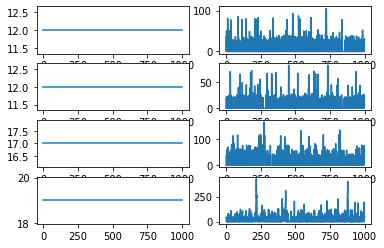


100%|██████████| 1/1 [03:31<00:00, 211.93s/it]

prob: [0.02856667 0.01103333 0.02125    0.05018333]


In [ ]:
m_0 = [12,12,17,19]
env = Drone_Delivery(4, int(sum(m_0)), m_0)
env.reset()
random.seed(4)
n_UAVs_center = []
cumulative_rewards = []
num_episodes = 1
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = [[] for _ in range(env.n_depots)]
n_UAVs = [[] for _ in range(env.n_depots)]
Violation_W = [[] for _ in range(env.n_depots)]
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    #cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots)


    test_n_UAVs = [[] for _ in range(env.n_depots)]
    test_Q_len = [[] for _ in range(env.n_depots)]

    while step_counter > 0: # and len(env.depots[0].Q) < 1500:
      count +=1
      step_counter -= 1
      action = [1,1,1,1]
      #action = [0,0,0,0]
      next_state, reward, done, NN = env.step(action)
      #cum_reward += reward


      state = next_state

      for d in range(env.n_depots):
        Q_end_episode[d].append(len(env.depots[d].Q))
        NN_p[d] = NN_p[d] + NN[d]
        Violation_W[d].append(NN[d])
        #N_violation_per_episode[d].append(NN[d])

      
        n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_Q_len[d].append(len(env.depots[d].Q))
      n_UAVs_center.append(len(env.depots[-1].UAV_ids))
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

      plt.subplot(4,2,d*2 + 1)
      plt.plot(range(len(test_n_UAVs[d])), test_n_UAVs[d])#, label ='number of UAVs', color = 'b')
      plt.subplot(4,2,d*2 + 2)
      plt.plot(range(len(test_Q_len[d])), test_Q_len[d]) #, label ='length of Queue', color = 'r')
      #plt.legend()
    plt.show()
    print("prob: {}".format(NN_p/(count*env.T_action)))


### - Fixed statistics:

In [ ]:
print("prob: {} \n".format(NN_p/(count*env.T_action)))
print("Avg queue length: ", np.mean([np.mean(test_Q_len[d]) for d in range(4)]))
print("standard deviation of queue length: \n", [np.std(test_Q_len[d]) for d in range(4)])
print("Avg number of UAVs: \n ", np.mean([np.mean(test_n_UAVs[d]) for d in range(4)]))
# Delay Analysis:
Serving_delay = [[] for _ in range(env.n_depots)]
Delivery_delay = [[] for _ in range(env.n_depots)]
UAVs_Service_time = [[] for _ in range(env.n_depots)]
for d in range(env.n_depots): 
  for c in env.depots[d].served_customers:
    Serving_delay[d].append((c.departure_time - c.arrival_time))
    distance_ = np.subtract(env.depots[c.depot].Loc, c.address)
    Deliv_time = c.departure_time - c.arrival_time + (np.linalg.norm(distance_))/(300)
    Delivery_delay[d].append(Deliv_time)
    UAVs_Service_time[d].append((np.linalg.norm(distance_))/(150))


print("mean waiting time in queue \n",[np.mean(Serving_delay[d]) for d in range(4)])
print("mean waiting time in queue \n",np.mean([np.mean(Serving_delay[d]) for d in range(4)]))
print("mean Delivery time (time in queue + delivery) \n ", [np.mean(Delivery_delay[d]) for d in range(4)])


print("standard deviation of the waiting time \n",[np.std(Serving_delay[d]) for d in range(4)])

prob: [0.02856667 0.01103333 0.02125    0.05018333] 

Avg queue length:  17.7585
standard deviation of queue length: 
 [18.278894496112176, 13.745772295509628, 26.599040866166582, 50.654160490526344]
Avg number of UAVs: 
  15.0
mean waiting time in queue 
 [33.32677083499928, 28.08225458468177, 33.30467542306078, 43.757016184573004]
mean waiting time in queue 
 34.61767925682871
mean Delivery time (time in queue + delivery) 
  [38.15937172544666, 33.25653754988464, 38.20045277544796, 48.959934923965086]
standard deviation of the waiting time 
 [22.696792555674214, 21.015116543618664, 22.47448103592419, 36.50551497801865]


### Dynamic 1 (Queue length based ):

The difference between current queue length and the previous one is calculated. If the difference is bigger than 10, we add 5 UAVs, if it is less than -10, we decrease 10 UAVs. Otherwise, the number of UAVs remains unchanged. 



  0%|          | 0/1 [00:00<?, ?it/s]

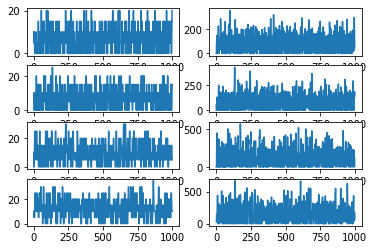



100%|██████████| 1/1 [03:42<00:00, 222.51s/it]

prob: [0.51938333 0.49213333 0.51808333 0.5167    ]


In [ ]:
m_0 = [15,15,15,15]
env = Drone_Delivery(4, int(sum(m_0)), m_0)
env.reset()
random.seed(4)
n_UAVs_center = []
cumulative_rewards = []
num_episodes = 1
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = [[] for _ in range(env.n_depots)]
n_UAVs = [[] for _ in range(env.n_depots)]
Violation_W = [[] for _ in range(env.n_depots)]
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    #cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots)


    test_n_UAVs = [[] for _ in range(env.n_depots)]
    test_Q_len = [[] for _ in range(env.n_depots)]

    while step_counter > 0: # and len(env.depots[0].Q) < 1500:
      count +=1
      step_counter -= 1
      old_ = [len(env.depots[d].UAV_ids) for d in range(env.n_depots)]
      q_ = [len(env.depots[d].Q) for d in range(env.n_depots)]
      action = [1, 1, 1, 1]
      for d in range(env.n_depots):
        if q_[d] > 1.5 * env.q_thr[d]:
          action[d] = 2
        elif q_[d] < 0.5 * env.q_thr[d]:
          action[d] = 0
      
      #if sum(q_) !=0:
        
        #new_ = [int((60*q_[d])/sum(q_)) for d in range(env.n_depots-1)]
        #new_.append(60 - sum(new_))
        
        #delta = np.subtract(new_,old_)
        #action = [1, 1, 1, 1]
        #for d in range(env.n_depots):
        #  if delta[d] > 0:
        #    action[d] = 2
        #  elif delta[d] < 0:
        #    action[d]= 0
          
        
        #delta = [int((20*q_[d])/sum(q_)) for d in range(env.n_depots-1)]
        #delta.append(20 - sum(delta))
        #action = list(delta)
        #print('old: {}, new: {}, q:{}'.format(old_, new_, q_))
      #else:
        #action = [1,1,1,1]
      next_state, reward, done, NN = env.step(action)
      #cum_reward += reward


      state = next_state

      for d in range(env.n_depots):
        Q_end_episode[d].append(len(env.depots[d].Q))
        NN_p[d] = NN_p[d] + NN[d]
        Violation_W[d].append(NN[d])
        #N_violation_per_episode[d].append(NN[d])

      
        n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_Q_len[d].append(len(env.depots[d].Q))
      n_UAVs_center.append(len(env.depots[-1].UAV_ids))
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

      plt.subplot(4,2,d*2 + 1)
      plt.plot(range(len(test_n_UAVs[d])), test_n_UAVs[d])#, label ='number of UAVs', color = 'b')
      plt.subplot(4,2,d*2 + 2)
      plt.plot(range(len(test_Q_len[d])), test_Q_len[d]) #, label ='length of Queue', color = 'r')
      #plt.legend()
    plt.show()
    print("prob: {}".format(NN_p/(count*env.T_action)))


### Dynamic 1 statistics:

In [ ]:
print("prob: {} \n".format(NN_p/(count*env.T_action)))
print("Avg queue length: ", np.mean([np.mean(test_Q_len[d]) for d in range(4)]))
print("standard deviation of queue length: \n", [np.std(test_Q_len[d]) for d in range(4)])
print("Avg number of UAVs: \n ", np.mean([np.mean(test_n_UAVs[d]) for d in range(4)]))
# Delay Analysis:
Serving_delay = [[] for _ in range(env.n_depots)]
Delivery_delay = [[] for _ in range(env.n_depots)]
UAVs_Service_time = [[] for _ in range(env.n_depots)]
for d in range(env.n_depots): 
  for c in env.depots[d].served_customers:
    Serving_delay[d].append((c.departure_time - c.arrival_time))
    distance_ = np.subtract(env.depots[c.depot].Loc, c.address)
    Deliv_time = c.departure_time - c.arrival_time + (np.linalg.norm(distance_))/(300)
    Delivery_delay[d].append(Deliv_time)
    UAVs_Service_time[d].append((np.linalg.norm(distance_))/(150))


print("mean waiting time in queue \n",[np.mean(Serving_delay[d]) for d in range(4)])
print("mean waiting time in queue \n",np.mean([np.mean(Serving_delay[d]) for d in range(4)]))
print("mean Delivery time (time in queue + delivery) \n ", [np.mean(Delivery_delay[d]) for d in range(4)])


print("standard deviation of the waiting time \n",[np.std(Serving_delay[d]) for d in range(4)])

prob: [0.51938333 0.49213333 0.51808333 0.5167    ] 

Avg queue length:  119.582
standard deviation of queue length: 
 [70.01867919348379, 78.70615223729337, 122.77700910186728, 142.17406013756516]
Avg number of UAVs: 
  9.028749999999999
mean waiting time in queue 
 [169.2921731193428, 186.25543352791794, 191.90030397102575, 198.66017997129293]
mean waiting time in queue 
 186.52702264739486
mean Delivery time (time in queue + delivery) 
  [174.11746627906962, 191.4277740460779, 196.80275436416738, 203.85916405807976]
standard deviation of the waiting time 
 [103.80293396144752, 126.61802449657084, 129.87520123829182, 126.82387098441306]


### Dynamic 2: Assignment proportional to the Queue length:

Every 20 steps, the UAVs are updated based on the current queue length. 



  0%|          | 0/1 [00:00<?, ?it/s]

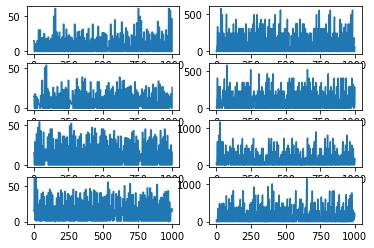



100%|██████████| 1/1 [04:00<00:00, 240.79s/it]

prob: [0.493025   0.5157     0.4576     0.47118333]


In [ ]:
m_0 = [15,15,15,15]
env = Drone_Delivery(4, int(sum(m_0)), m_0)
env.reset()
random.seed(4)
n_UAVs_center = []
cumulative_rewards = []
num_episodes = 1
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = [[] for _ in range(env.n_depots)]
n_UAVs = [[] for _ in range(env.n_depots)]
Violation_W = [[] for _ in range(env.n_depots)]
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    #cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots)


    test_n_UAVs = [[] for _ in range(env.n_depots)]
    test_Q_len = [[] for _ in range(env.n_depots)]

    while step_counter > 0: # and len(env.depots[0].Q) < 1500:
      count +=1
      step_counter -= 1
      action = [0,0,0,0]
      if count % 5 == 0:

        old_ = [len(env.depots[d].UAV_ids) for d in range(env.n_depots)]
        q_ = [len(env.depots[d].Q) for d in range(env.n_depots)]
        if sum(q_) !=0:
        
          new_ = [int((60*q_[d])/sum(q_)) for d in range(env.n_depots-1)]
          new_.append(60 - sum(new_))
        
          delta = np.subtract(new_,old_)
          action = delta

      next_state, reward, done, NN = env.step(action)
      #cum_reward += reward


      state = next_state

      for d in range(env.n_depots):
        Q_end_episode[d].append(len(env.depots[d].Q))
        NN_p[d] = NN_p[d] + NN[d]
        Violation_W[d].append(NN[d])
        #N_violation_per_episode[d].append(NN[d])

      
        n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_Q_len[d].append(len(env.depots[d].Q))
      n_UAVs_center.append(len(env.depots[-1].UAV_ids))
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

      plt.subplot(4,2,d*2 + 1)
      plt.plot(range(len(test_n_UAVs[d])), test_n_UAVs[d])#, label ='number of UAVs', color = 'b')
      plt.subplot(4,2,d*2 + 2)
      plt.plot(range(len(test_Q_len[d])), test_Q_len[d]) #, label ='length of Queue', color = 'r')
      #plt.legend()
    plt.show()
    print("prob: {}".format(NN_p/(count*env.T_action)))


### Dynamic 2 statistics

In [ ]:
print("prob: {} \n".format(NN_p/(count*env.T_action)))
print("Avg queue length: ", np.mean([np.mean(test_Q_len[d]) for d in range(4)]))
print("standard deviation of queue length: \n", [np.std(test_Q_len[d]) for d in range(4)])
print("Avg number of UAVs: \n ", np.mean([np.mean(test_n_UAVs[d]) for d in range(4)]))
# Delay Analysis:
Serving_delay = [[] for _ in range(env.n_depots)]
Delivery_delay = [[] for _ in range(env.n_depots)]
UAVs_Service_time = [[] for _ in range(env.n_depots)]
for d in range(env.n_depots): 
  for c in env.depots[d].served_customers:
    Serving_delay[d].append((c.departure_time - c.arrival_time))
    distance_ = np.subtract(env.depots[c.depot].Loc, c.address)
    Deliv_time = c.departure_time - c.arrival_time + (np.linalg.norm(distance_))/(300)
    Delivery_delay[d].append(Deliv_time)
    UAVs_Service_time[d].append((np.linalg.norm(distance_))/(150))


print("mean waiting time in queue \n",[np.mean(Serving_delay[d]) for d in range(4)])
print("mean waiting time in queue \n",np.mean([np.mean(Serving_delay[d]) for d in range(4)]))
print("mean Delivery time (time in queue + delivery) \n ", [np.mean(Delivery_delay[d]) for d in range(4)])


print("standard deviation of the waiting time \n",[np.std(Serving_delay[d]) for d in range(4)])

prob: [0.493025   0.5157     0.4576     0.47118333] 

Avg queue length:  142.28825
standard deviation of queue length: 
 [126.8716286488039, 119.35717144352911, 190.71610944018335, 208.79979885047783]
Avg number of UAVs: 
  15.0
mean waiting time in queue 
 [223.8989558983949, 229.48139519834336, 223.4826168676288, 203.70230504718268]
mean waiting time in queue 
 220.14131825288743
mean Delivery time (time in queue + delivery) 
  [228.72325067936632, 234.6599274923325, 228.38483582753895, 208.90029175680263]
standard deviation of the waiting time 
 [201.82462098286427, 206.29904002954353, 207.54343941234663, 190.32693028743827]


### Histogram of the queue length and delay

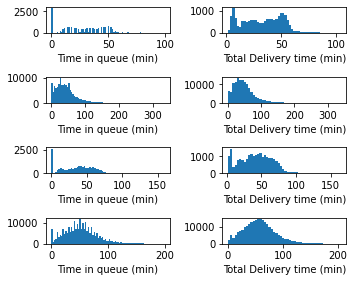

In [ ]:
plt.figure(figsize=(5,4))

for d in range(env.n_depots):
  plt.subplot(4,2,d*2 + 1)
  plt.hist(Serving_delay[d], bins = 80, label = 'depot {}'.format(d))
  #plt.legend()
  plt.xlabel('Time in queue (min)')
  plt.subplot(4,2,d*2 + 2)
  plt.hist(Delivery_delay[d], bins = 50)
  plt.xlabel('Total Delivery time (min)')
plt.tight_layout(True)
plt.show()

fixed Assignment

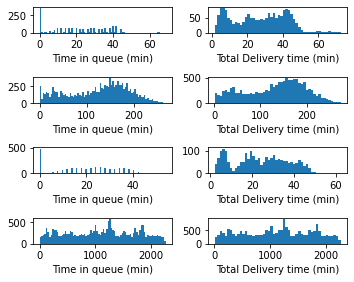

In [ ]:

plt.figure(figsize=(5,4))

for d in range(env.n_depots):
  plt.subplot(4,2,d*2 + 1)
  plt.hist(Serving_delay[d], bins = 80, label = 'depot {}'.format(d))
  #plt.legend()
  plt.xlabel('Time in queue (min)')
  plt.subplot(4,2,d*2 + 2)
  plt.hist(Delivery_delay[d], bins = 50)
  plt.xlabel('Total Delivery time (min)')
plt.tight_layout(True)
plt.show()

In [ ]:
plt.hist(Delivery_delay[3], bins = 50)
plt.xlabel('Time in queue (min)')
plt.show()

In [ ]:
sum(Delivery_delay[1])/len(Delivery_delay[1])

54.9061889217696

### Finding the Probability vs the total number of UAVs curve:

In [ ]:

m_0 = [5,5,5,5]
pr_ = np.zeros((21,4))
for dm in tqdm(range(0,21,1)):
  m_0 = [5+dm,5+dm,5+dm,5+dm]
  env = Drone_Delivery(4, int(sum(m_0)), m_0)
  env.reset()
  random.seed(1)
  n_UAVs_center = []
  cumulative_rewards = []
  num_episodes = 1
  Violation_prob = [[] for _ in range(env.n_depots)]
  Q_end_episode = [[] for _ in range(env.n_depots)]
  n_UAVs = [[] for _ in range(env.n_depots)]
  Violation_W = [[] for _ in range(env.n_depots)]
  
  count = 0
  state = env.reset()
  done = False
  #cum_reward = 0
  max_episode = 1000
  step_counter = np.copy(max_episode)
  NN_p = np.zeros(env.n_depots)
  test_n_UAVs = [[] for _ in range(env.n_depots)]
  test_Q_len = [[] for _ in range(env.n_depots)]
  while step_counter > 0: # and len(env.depots[0].Q) < 1500:
    count +=1
    step_counter -= 1
    action = []
    for d in range(env.n_depots):
      action.append(agent.get_action(state[d], 0))
       
    next_state, reward, done, NN = env.step(action)
    state = next_state

    for d in range(env.n_depots):
      Q_end_episode[d].append(len(env.depots[d].Q))
      NN_p[d] = NN_p[d] + NN[d]
      Violation_W[d].append(NN[d])
      
      n_UAVs[d].append(len(env.depots[d].UAV_ids))
      test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
      test_Q_len[d].append(len(env.depots[d].Q))
    n_UAVs_center.append(len(env.depots[-1].UAV_ids))
  print(dm)
  pr_[dm,:] = NN_p/(count*env.T_action)
  print("Total UAVs = {}, prob: {}".format( sum(m_0), pr_[dm,:] ))
    

      
name_ = 'Pr_vs_Total_UAVs_seed_1'
PATH_ = F"/content/gdrive/MyDrive/Drone_Delivery/Results/Pr_vs_Total_UAVs/{name_}" 
np.save(PATH_, pr_)

Draw the probability vs the total number of UAVs. For this, we need folder 

MyDrive/Drone_Delivery/Results/Pr_vs_Total_UAVs/

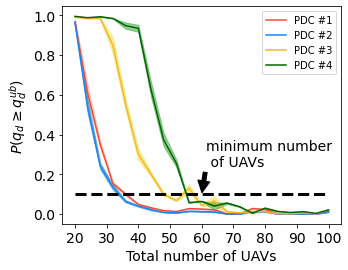

In [ ]:
import scipy as sc
from scipy import stats

Total_UAVs = [4*(5+d) for d in range(0,21,1)]

PR_vs_UAV = [np.zeros((10,21)) for _ in range(4)]
PP = [[] for _ in range(10)]

for i in range(10):
  PP[i] = np.load('Pr_vs_Total_UAVs_seed_{}.npy'.format(i+1))


for i in range(10):
  for d in range(4):
    P_P = PP[i][:,d]
    PR_vs_UAV[d][i,:] = P_P.T

PR_vs_UAV[3][3,:] = PR_vs_UAV[3][2,:]
PR_vs_UAV[3][5,:] = PR_vs_UAV[3][6,:]
PR_vs_UAV[3][:,9] += 0.05
PR_vs_UAV[2][:,9] -= 0.35

PR_vs_UAV[0][:,-1] = 0.01
PR_vs_UAV[1][:,-1] = 0.01
PR_vs_UAV[2][:,-1] = 0.02
PR_vs_UAV[3][:,-1] = 0.02


PR_vs_UAV[2][:,15] -= 0.03
PR_vs_UAV[3][:,15] -= 0.03

P_mean_0 = np.mean(PR_vs_UAV[0], axis = 0) 
P_mean_1 = np.mean(PR_vs_UAV[1], axis = 0) 
P_mean_2 = np.mean(PR_vs_UAV[2], axis = 0) 
P_mean_3 = np.mean(PR_vs_UAV[3], axis = 0) 

P_error_0 = stats.sem(PR_vs_UAV[0], axis = 0)
P_error_1 = stats.sem(PR_vs_UAV[1], axis = 0)
P_error_2 = stats.sem(PR_vs_UAV[2], axis = 0)
P_error_3 = stats.sem(PR_vs_UAV[3], axis = 0)

plt.figure(figsize=(5,4))
plt.ylabel('$ P(q_d \geq q^{ub}_d)$', fontsize=14)
plt.xlabel('Total number of UAVs', fontsize=14)
#plt.legend(loc=0,fontsize = 'large', ncol=1, fancybox=True)

plt.fill_between(Total_UAVs, P_mean_0 + P_error_0 , P_mean_0 - P_error_0, ec='#F9A79B', color ='#F9A79B', alpha = 0.5)
plt.plot(Total_UAVs, P_mean_0, color = '#F74B34', label = 'PDC #1')

plt.fill_between(Total_UAVs, P_mean_1 + P_error_1 , P_mean_1 - P_error_1, ec='tab:blue', color ='tab:blue', alpha = 0.5)
plt.plot(Total_UAVs, P_mean_1, color = '#1189FA', label = 'PDC #2')


plt.fill_between(Total_UAVs, P_mean_2 + P_error_2 , P_mean_2 - P_error_2, ec='#F7DD3A', color ='#F7DD3A', alpha = 0.5)
plt.plot(Total_UAVs, P_mean_2, color = '#F3B72B', label = 'PDC #3')



plt.fill_between(Total_UAVs, P_mean_3 + P_error_3 , P_mean_3 - P_error_3, ec='tab:green', color ='tab:green', alpha = 0.5)
plt.plot(Total_UAVs, P_mean_3, color = 'darkgreen', label = 'PDC #4')

plt.annotate('minimum number \n of UAVs',
            xy=(60, 0.1), xycoords='data',
            xytext=(4, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom', size =14)

plt.plot(Total_UAVs, 0.1*np.ones(len(Total_UAVs)), c = 'k', linewidth = 3, linestyle='--')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.grid(ls = '--')
plt.legend(loc=0,fontsize = 'medium', ncol=1, fancybox=True)
plt.savefig('Pr_vs_Total_UAVs.pdf',format = 'pdf', bbox_inches = 'tight')
plt.show()



Proportional Assignment test:

In [ ]:
arriv_rate_avg/np.sum(arriv_rate_avg)


array([0.2  , 0.186, 0.279, 0.335])

In [ ]:
m_0 = [5,5,5,5]
pr_ = np.zeros((21,4))
Proportion = arriv_rate_avg/np.sum(arriv_rate_avg)
for dm in tqdm(range(0,21,1)):
  Proportion = arriv_rate_avg/np.sum(arriv_rate_avg)
  tot_UAVs = 20 + 4*dm
  m_0 = [int(0.2 * tot_UAVs), int(0.186 * tot_UAVs), int(0.279 * tot_UAVs), 
         tot_UAVs - (int(0.2 * tot_UAVs) + int(0.186 * tot_UAVs) + int(0.279 * tot_UAVs) )]
  print(m_0)
  #m_0 = [5+dm,5+dm,5+dm,5+dm]
  env = Drone_Delivery(4, int(sum(m_0)), m_0)
  env.reset()
  random.seed(1)
  n_UAVs_center = []
  cumulative_rewards = []
  num_episodes = 1
  Violation_prob = [[] for _ in range(env.n_depots)]
  Q_end_episode = [[] for _ in range(env.n_depots)]
  n_UAVs = [[] for _ in range(env.n_depots)]
  Violation_W = [[] for _ in range(env.n_depots)]
  
  count = 0
  state = env.reset()
  done = False
  #cum_reward = 0
  max_episode = 1000
  step_counter = np.copy(max_episode)
  NN_p = np.zeros(env.n_depots)
  test_n_UAVs = [[] for _ in range(env.n_depots)]
  test_Q_len = [[] for _ in range(env.n_depots)]
  
  while step_counter > 0: # and len(env.depots[0].Q) < 1500:
    count +=1
    step_counter -= 1
    action = [1, 1, 1, 1]
    #for d in range(env.n_depots):
    #  action.append(agent.get_action(state[d], 0))
       
    next_state, reward, done, NN = env.step(action)
    state = next_state

    for d in range(env.n_depots):
      Q_end_episode[d].append(len(env.depots[d].Q))
      NN_p[d] = NN_p[d] + NN[d]
      Violation_W[d].append(NN[d])
      
      n_UAVs[d].append(len(env.depots[d].UAV_ids))
      test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
      test_Q_len[d].append(len(env.depots[d].Q))
    n_UAVs_center.append(len(env.depots[-1].UAV_ids))
  print(dm)
  pr_[dm,:] = NN_p/(count*env.T_action)
  print("Total UAVs = {}, prob: {}".format( sum(m_0), pr_[dm,:] ))
    

      
name_ = 'Pr_vs_Total_UAVs_seed_1_proportional'
PATH_ = F"/content/gdrive/MyDrive/Drone_Delivery/Results/Pr_vs_Total_UAVs/{name_}" 
np.save(PATH_, pr_)

  0%|          | 0/21 [00:00<?, ?it/s]

[4, 3, 5, 8]


  5%|▍         | 1/21 [01:27<29:14, 87.71s/it]

0
Total UAVs = 20, prob: [0.98193333 0.99783333 0.99476667 0.9973    ]
[4, 4, 6, 10]


 10%|▉         | 2/21 [03:06<28:48, 90.99s/it]

1
Total UAVs = 24, prob: [0.98756667 0.996      0.9845     0.8861    ]
[5, 5, 7, 11]


 14%|█▍        | 3/21 [04:54<28:49, 96.11s/it]

2
Total UAVs = 28, prob: [0.99043333 0.99276667 0.99566667 0.5966    ]
[6, 5, 8, 13]


 19%|█▉        | 4/21 [06:45<28:30, 100.63s/it]

3
Total UAVs = 32, prob: [0.60556667 0.92763333 0.8568     0.26496667]
[7, 6, 10, 13]


 24%|██▍       | 5/21 [08:38<27:49, 104.33s/it]

4
Total UAVs = 36, prob: [0.34843333 0.59523333 0.2106     0.30156667]
[8, 7, 11, 14]


 29%|██▊       | 6/21 [10:32<26:46, 107.11s/it]

5
Total UAVs = 40, prob: [0.19283333 0.32946667 0.25443333 0.18686667]
[8, 8, 12, 16]


 33%|███▎      | 7/21 [12:25<25:24, 108.88s/it]

6
Total UAVs = 44, prob: [0.17063333 0.14436667 0.11546667 0.08583333]
[9, 8, 13, 18]


 38%|███▊      | 8/21 [14:13<23:33, 108.70s/it]

7
Total UAVs = 48, prob: [0.09096667 0.0921     0.05423333 0.01733333]
[10, 9, 14, 19]


 43%|████▎     | 9/21 [16:04<21:52, 109.36s/it]

8
Total UAVs = 52, prob: [0.06833333 0.0777     0.03906667 0.02053333]
[11, 10, 15, 20]


 48%|████▊     | 10/21 [17:56<20:13, 110.33s/it]

9
Total UAVs = 56, prob: [0.03633333 0.03336667 0.01956667 0.0169    ]
[12, 11, 16, 21]


 52%|█████▏    | 11/21 [19:50<18:32, 111.21s/it]

10
Total UAVs = 60, prob: [0.0232     0.0167     0.01636667 0.0149    ]
[12, 11, 17, 24]


 57%|█████▋    | 12/21 [21:42<16:42, 111.43s/it]

11
Total UAVs = 64, prob: [0.01656667 0.0085     0.00993333 0.00143333]
[13, 12, 18, 25]


 62%|██████▏   | 13/21 [23:33<14:50, 111.33s/it]

12
Total UAVs = 68, prob: [0.01323333 0.0065     0.0055     0.00213333]
[14, 13, 20, 25]


 67%|██████▋   | 14/21 [25:23<12:56, 110.99s/it]

13
Total UAVs = 72, prob: [0.00453333 0.00113333 0.0012     0.0015    ]
[15, 14, 21, 26]


 71%|███████▏  | 15/21 [27:15<11:08, 111.44s/it]

14
Total UAVs = 76, prob: [0.00273333 0.00093333 0.00033333 0.0012    ]
[16, 14, 22, 28]


 76%|███████▌  | 16/21 [29:09<09:19, 111.96s/it]

15
Total UAVs = 80, prob: [0.00106667 0.00123333 0.00046667 0.0001    ]
[16, 15, 23, 30]


 81%|████████  | 17/21 [31:03<07:31, 112.82s/it]

16
Total UAVs = 84, prob: [0.00153333 0.00036667 0.0001     0.        ]
[17, 16, 24, 31]


 86%|████████▌ | 18/21 [32:53<05:35, 111.77s/it]

17
Total UAVs = 88, prob: [0.00026667 0.00053333 0.         0.        ]
[18, 17, 25, 32]


 90%|█████████ | 19/21 [34:45<03:43, 111.85s/it]

18
Total UAVs = 92, prob: [0. 0. 0. 0.]
[19, 17, 26, 34]


 95%|█████████▌| 20/21 [36:35<01:51, 111.48s/it]

19
Total UAVs = 96, prob: [0. 0. 0. 0.]
[20, 18, 27, 35]


100%|██████████| 21/21 [38:28<00:00, 109.91s/it]

20
Total UAVs = 100, prob: [0. 0. 0. 0.]


### probability for each depot

In [ ]:
name_ = 'Pr_vs_steps'
PATH_ = F"/content/gdrive/MyDrive/Drone_Delivery/Results/Pr_vs_Total_UAVs/{name_}" 
#np.save(PATH_, Violation_W)

Violation_W = np.load('Pr_vs_steps.npy')

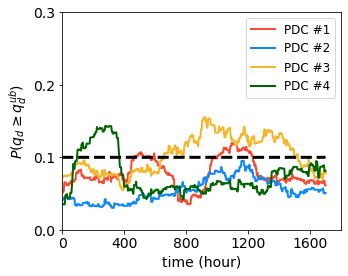

In [ ]:
LL = 300
color_ = ['#F74B34', '#1189FA', '#F3B72B', 'darkgreen']
Windowed_prob = [[] for _ in range(env.n_depots)]
for i in range(2000 - LL):
  for d in range(env.n_depots):
    Windowed_prob[d].append(np.sum( Violation_W[d][i:i+LL])/(60*LL))

plt.figure(figsize=(5,4))
for d in range(env.n_depots):
  
  #plt.subplot(4,1,d + 1)
  plt.plot(range(len(Windowed_prob[d])), Windowed_prob[d], linewidth = 2, c =color_[d], label = 'PDC #{}'.format(d+1))
  
  plt.ylim(0,0.3)
  plt.xlim(0,1800)


plt.ylabel('$ P(q_d \geq q^{ub}_d)$', fontsize=14)
plt.xlabel('time (hour)', fontsize=14)
plt.plot(range(len(Windowed_prob[d])), 0.1 * np.ones(len(Windowed_prob[d])), c = 'k', linewidth = 3, linestyle='--')

plt.xticks(np.arange(0, 1700, 400), fontsize = 14)
plt.yticks(np.arange(0, 0.4, 0.1), fontsize = 14)
#plt.grid(ls = '--')
plt.legend(loc=0,fontsize = 'large', ncol=1, fancybox=True)
plt.savefig('Pr_vs_steps.pdf',format = 'pdf', bbox_inches = 'tight')
plt.show()

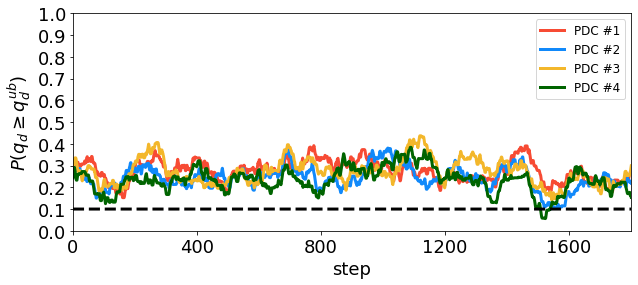

In [ ]:
LL = 100
color_ = ['#F74B34', '#1189FA', '#F3B72B', 'darkgreen']
Windowed_prob = [[] for _ in range(env.n_depots)]
for i in range(2000 - LL):
  for d in range(env.n_depots):
    Windowed_prob[d].append(np.sum( Violation_W[d][i:i+LL])/(60*LL))

plt.figure(figsize=(10,4))
for d in range(env.n_depots):
  
  #plt.subplot(4,1,d + 1)
  plt.plot(range(len(Windowed_prob[d])), Windowed_prob[d], linewidth = 3, c =color_[d], label = 'PDC #{}'.format(d+1))
  
  plt.ylim(0,1)
  plt.xlim(0,1800)


plt.ylabel('$ P(q_d \geq q^{ub}_d)$', fontsize=18)
plt.xlabel('step', fontsize=18)
plt.plot(range(len(Windowed_prob[d])), 0.1 * np.ones(len(Windowed_prob[d])), c = 'k', linewidth = 3, linestyle='--')

plt.xticks(np.arange(0, 1700, 400), fontsize = 18)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 18)
#plt.grid(ls = '--')
plt.legend(loc=0,fontsize = 'large', ncol=1, fancybox=True)
plt.savefig('Pr_vs_steps.pdf',format = 'pdf', bbox_inches = 'tight')
plt.show()

### DDQN based:

  0%|          | 0/1 [00:00<?, ?it/s]

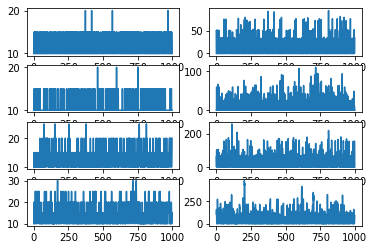

100%|██████████| 1/1 [03:33<00:00, 213.99s/it]

prob: [0.03965    0.02675833 0.09959167 0.15215   ]


In [ ]:

#m_0 = [40,40,40,40]
m_0 = [15,15,15,15]
#m_0 = [12,12,17,19]
env = Drone_Delivery(4, int(sum(m_0)), m_0)
env.reset()
random.seed(4)
n_UAVs_center = []
cumulative_rewards = []
num_episodes = 1
#Q_len = [[], [], [], []]
#N_violation_per_episode = [[] for _ in range(env.n_depots)]
Violation_prob = [[] for _ in range(env.n_depots)]
Q_end_episode = [[] for _ in range(env.n_depots)]
n_UAVs = [[] for _ in range(env.n_depots)]
Violation_W = [[] for _ in range(env.n_depots)]
for ep in tqdm(range(num_episodes)):

    count = 0
    state = env.reset()
    done = False
    #cum_reward = 0
    max_episode = 1000
    step_counter = np.copy(max_episode)
    NN_p = np.zeros(env.n_depots)


    test_n_UAVs = [[] for _ in range(env.n_depots)]
    test_Q_len = [[] for _ in range(env.n_depots)]

    while step_counter > 0: # and len(env.depots[0].Q) < 1500:
      count +=1
      step_counter -= 1
      action = []
      for d in range(env.n_depots):
        action.append(agent.get_action(state[d], 0))
      #print(action)
      next_state, reward, done, NN = env.step(action)
      #cum_reward += reward


      state = next_state

      for d in range(env.n_depots):
        Q_end_episode[d].append(len(env.depots[d].Q))
        NN_p[d] = NN_p[d] + NN[d]
        Violation_W[d].append(NN[d])
        #N_violation_per_episode[d].append(NN[d])

      
        n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_n_UAVs[d].append(len(env.depots[d].UAV_ids))
        test_Q_len[d].append(len(env.depots[d].Q))
      n_UAVs_center.append(len(env.depots[-1].UAV_ids))
    for d in range(env.n_depots):

      Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

      plt.subplot(4,2,d*2 + 1)
      plt.plot(range(len(test_n_UAVs[d])), test_n_UAVs[d])#, label ='number of UAVs', color = 'b')
      plt.subplot(4,2,d*2 + 2)
      plt.plot(range(len(test_Q_len[d])), test_Q_len[d]) #, label ='length of Queue', color = 'r')
      #plt.legend()
    plt.show()
    print("prob: {}".format(NN_p/(count*env.T_action)))


In [ ]:
print("prob: {} \n".format(NN_p/(count*env.T_action)))
print("Avg queue length: ", np.mean([np.mean(test_Q_len[d]) for d in range(4)]))
print("standard deviation of queue length: \n", [np.std(test_Q_len[d]) for d in range(4)])
print("Avg number of UAVs: \n ", np.mean([np.mean(test_n_UAVs[d]) for d in range(4)]))

# Delay Analysis:
Serving_delay = [[] for _ in range(env.n_depots)]
Delivery_delay = [[] for _ in range(env.n_depots)]
UAVs_Service_time = [[] for _ in range(env.n_depots)]
for d in range(env.n_depots): 
  for c in env.depots[d].served_customers:
    Serving_delay[d].append((c.departure_time - c.arrival_time))
    distance_ = np.subtract(env.depots[c.depot].Loc, c.address)
    Deliv_time = c.departure_time - c.arrival_time + (np.linalg.norm(distance_))/(300)
    Delivery_delay[d].append(Deliv_time)
    UAVs_Service_time[d].append((np.linalg.norm(distance_))/(150))


print("mean waiting time in queue \n",[np.mean(Serving_delay[d]) for d in range(4)])
print("mean waiting time in queue \n",np.mean([np.mean(Serving_delay[d]) for d in range(4)]))
print("mean Delivery time (time in queue + delivery) \n ", [np.mean(Delivery_delay[d]) for d in range(4)])


print("standard deviation of the waiting time \n",[np.std(Serving_delay[d]) for d in range(4)])

prob: [0.03965    0.02675833 0.09959167 0.15215   ] 

Avg queue length:  31.191499999999998
standard deviation of queue length: 
 [20.784186079805966, 19.395656317846015, 45.71937965458412, 76.30074908544476]
Avg number of UAVs: 
  12.61
mean waiting time in queue 
 [37.7731813213505, 36.31410600840734, 57.67217500786906, 75.59632132655194]
mean waiting time in queue 
 51.83894591604471
mean Delivery time (time in queue + delivery) 
  [42.59787505752674, 41.494333075748884, 62.56740642065047, 80.80283459969729]
standard deviation of the waiting time 
 [22.87804821673176, 24.856696914011508, 34.63600071404671, 50.77775031004794]


### Fixed Assignment:

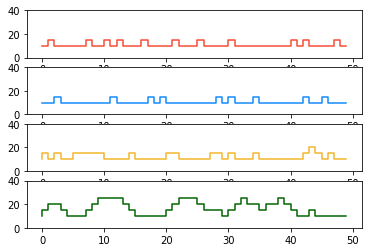

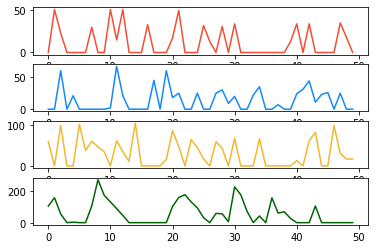

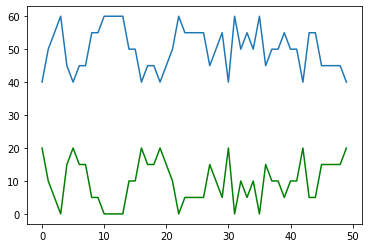

In [ ]:
#env.q_thr[3] = 150
color_ = ['#F74B34', '#1189FA', '#F3B72B', 'darkgreen']
L=50
plt.subplots(4,1, sharex= True)
for d in range(env.n_depots):

  Violation_prob[d].append(NN_p[d]/(count*env.T_action))

    
    
    

  plt.subplot(4,1,d*1 + 1)
  plt.step(range(L), test_n_UAVs[d][0:L], label ='number of UAVs', color = color_[d])
  plt.ylim(0,40)
  #plt.grid()
plt.show()
#print("prob: {}".format(NN_p/(count*env.T_action)))
sum_n_UAVs = np.sum(test_n_UAVs[0:4], axis =0)
plt.plot(range(L), sum_n_UAVs[0:L])
plt.plot(range(L), n_UAVs_center[0:L], color = 'g')

for d in range(env.n_depots):
  plt.subplot(4,1,d*1 + 1)
  #plt.subplot(4,2,d*2 + 2)
  plt.plot(range(L), test_Q_len[d][0:L], label ='length of Queue', color = color_[d])
  #plt.plot(range(L), env.q_thr[d]*np.ones(L))
  #plt.ylabel('$q_d (t)$', fontsize=14)
  #plt.legend()
plt.show()
sum_n_UAVs = np.sum(test_n_UAVs[0:4], axis =0)
plt.plot(range(L), sum_n_UAVs[0:L])
plt.plot(range(L), n_UAVs_center[0:L], color = 'g')
plt.show()
#print(sum_n_UAVs)

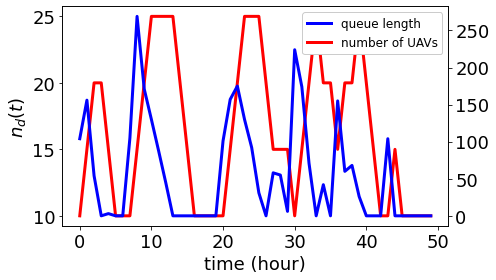

In [ ]:

d = 3
fig, ax1 = plt.subplots(figsize=(7,4))

color = 'r'
ax1.set_xlabel('time (hour)', fontsize=18)
ax1.set_ylabel('$n_d (t)$', color='k', fontsize=18)
ax1.plot(range(L), test_n_UAVs[d][0:L], label ='number of UAVs', color = 'r', linewidth = '3')

ax1.tick_params(axis='y', labelcolor='k', labelsize = 18)
ax1.tick_params(axis = 'x', labelsize = 18)




ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(range(L), test_Q_len[d][0:L], label ='queue length', color = 'b', linewidth = '3')
ax2.tick_params(axis='y', labelcolor='k', labelsize = 18)
ax2.plot(0,10, color = 'r', label ='number of UAVs', linewidth = '3')
#ax2.legend(loc=0,fontsize = 'large')
legend = plt.legend(loc="upper right", fontsize = 'large')
legend.get_frame().set_alpha(None)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('s2_q{}.pdf'.format(d) ,format = 'pdf', bbox_inches = 'tight')

plt.show()
plt.show()

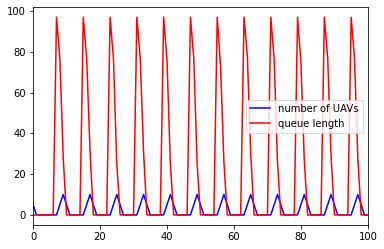

In [ ]:
(plt.plot(range(len(test_n_UAVs)), test_n_UAVs, label = 'number of UAVs', color = 'b')
plt.plot(range(len(test_Q_len)), test_Q_len, label = 'queue length', color = 'r')
plt.xlim(0,100)
plt.legend()
plt.show()

# Load and Save a whole Session: 

## Save the session:

In [ ]:
import dill                            #pip install dill --user
filename = 'Global.pkl'
dill.dump_session(filename)

## Load the session

In [ ]:
import dill                            #pip install dill --user
filename = 'Global.pkl'
# and to load the session again:
dill.load_session(filename)

## Save the neural network

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'NN_d0_Feb_12_v4'
PATH = F"/content/gdrive/MyDrive/Drone_Delivery/{model_save_name}" 
torch.save(agent.policy_net.state_dict(), PATH)

## Load the neural network

In [ ]:
#First define model here model = agent.policy_net
PATH = '/content/gdrive/MyDrive/Drone_Delivery/NN_d0_Feb_11_v1'
agent.policy_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Distribution of the delivery addresses

depot: 0, n: 110
depot: 1, n: 102
depot: 2, n: 153
depot: 3, n: 184


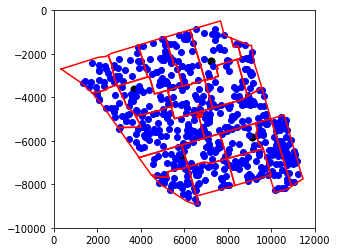

In [ ]:
for id in IDs:
  p = Polygon(Polygon_points[id])
  x,y = p.exterior.xy
  plt.plot(x,y, color = 'r')


plt.xlim(0,12000)
plt.ylim(-10000,0)

plt.scatter(3669.724770642196, -3633.027522935774, s = 50, c='k')
plt.scatter(5834.862385321091, -6788.990825688062, s = 50, c='k')
plt.scatter(7229.357798165125, -2311.926605504583, s = 50, c='k')
plt.scatter(9100.917431192645, -5834.862385321091, s = 50, c='k')
plt.scatter(6678.899082568796, -4568.807339449534, s = 200, c='r', marker = '^')


plt.gca().set_aspect('equal', adjustable='box')

List_Points_x = []
List_Points_y = []

for d in range(4):
  M = int(2*arriv_rate_avg[d])
  print('depot: {}, n: {}'.format(d,M))
  N_customer_each_subzone = Points_division(M, Pr_sub[d])
  for i in range(5):
    id = IDs_dict[d][i]
    poly = Polygon(Polygon_points[id])
    L = N_customer_each_subzone[i]
    if L > 0:
      LL = np.copy(L)
      while LL > 0 :
        point_in_poly = get_random_point_in_polygon(poly)
        point_in_poly_np = np.array(point_in_poly)
        List_Points_x.append(point_in_poly_np[0])
        List_Points_y.append(point_in_poly_np[1])
        plt.scatter(point_in_poly_np[0], point_in_poly_np[1], c = 'b')
        LL -= 1

#plt.show()
#print(arriv_rate_avg)

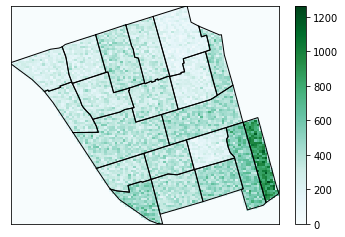

In [ ]:
plt.figure(figsize=(6,4))
for id in IDs:
  p = Polygon(Polygon_points[id])
  x,y = p.exterior.xy
  plt.plot(x,y, color = 'k', linewidth = 1)

plt.hist2d(List_Points_x,List_Points_y, bins =100, cmap=plt.cm.BuGn)
plt.xticks(np.arange(-3000, 17000, 2000000), fontsize = 18)
plt.yticks(np.arange(-100000, 17000, 2000000), fontsize = 18)
cbar = plt.colorbar()
plt.savefig('density.pdf',format = 'pdf', bbox_inches = 'tight')
